# Fully-Connected Neural Nets
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def layer_forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def layer_backward(dout, cache):
  """
  Receive derivative of loss with respect to outputs and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer and Batch Normalization as a tool to more efficiently optimize deep networks.
  

In [133]:
# As usual, a bit of setup
from __future__ import print_function
import time
import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifiers.fc_net import *
from cs231n.data_utils import get_CIFAR10_data
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [134]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in list(data.items()):
  print(('%s: ' % k, v.shape))

('X_train: ', (49000, 3, 32, 32))
('y_train: ', (49000,))
('X_val: ', (1000, 3, 32, 32))
('y_val: ', (1000,))
('X_test: ', (1000, 3, 32, 32))
('y_test: ', (1000,))


# Affine layer: foward
Open the file `cs231n/layers.py` and implement the `affine_forward` function.

Once you are done you can test your implementaion by running the following:

In [135]:
# Test the affine_forward function

num_inputs = 2
input_shape = (4, 5, 6)
output_dim = 3

input_size = num_inputs * np.prod(input_shape)
weight_size = output_dim * np.prod(input_shape)

x = np.linspace(-0.1, 0.5, num=input_size).reshape(num_inputs, *input_shape)
w = np.linspace(-0.2, 0.3, num=weight_size).reshape(np.prod(input_shape), output_dim)
b = np.linspace(-0.3, 0.1, num=output_dim)

out, _ = affine_forward(x, w, b)
correct_out = np.array([[ 1.49834967,  1.70660132,  1.91485297],
                        [ 3.25553199,  3.5141327,   3.77273342]])

# Compare your output with ours. The error should be around 1e-9.
print('Testing affine_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing affine_forward function:
difference:  9.76984772881e-10


# Affine layer: backward
Now implement the `affine_backward` function and test your implementation using numeric gradient checking.

In [136]:
# Test the affine_backward function
np.random.seed(231)
x = np.random.randn(10, 2, 3)
w = np.random.randn(6, 5)
b = np.random.randn(5)
dout = np.random.randn(10, 5)

dx_num = eval_numerical_gradient_array(lambda x: affine_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_forward(x, w, b)[0], b, dout)

_, cache = affine_forward(x, w, b)
dx, dw, db = affine_backward(dout, cache)

# The error should be around 1e-10
print('Testing affine_backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_backward function:
dx error:  5.39910036865e-11
dw error:  9.9042118654e-11
db error:  2.41228675681e-11


# ReLU layer: forward
Implement the forward pass for the ReLU activation function in the `relu_forward` function and test your implementation using the following:

In [137]:
# Test the relu_forward function

x = np.linspace(-0.5, 0.5, num=12).reshape(3, 4)

out, _ = relu_forward(x)
correct_out = np.array([[ 0.,          0.,          0.,          0.,        ],
                        [ 0.,          0.,          0.04545455,  0.13636364,],
                        [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]])

# Compare your output with ours. The error should be around 5e-8
print('Testing relu_forward function:')
print('difference: ', rel_error(out, correct_out))

Testing relu_forward function:
difference:  4.99999979802e-08


# ReLU layer: backward
Now implement the backward pass for the ReLU activation function in the `relu_backward` function and test your implementation using numeric gradient checking:

In [138]:
np.random.seed(231)
x = np.random.randn(10, 10)
dout = np.random.randn(*x.shape)

dx_num = eval_numerical_gradient_array(lambda x: relu_forward(x)[0], x, dout)

_, cache = relu_forward(x)
dx = relu_backward(dout, cache)

# The error should be around 3e-12
# print(dx_num, dx)
print('Testing relu_backward function:')
print('dx error: ', rel_error(dx_num, dx))

Testing relu_backward function:
dx error:  3.27563491363e-12


# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, affine layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define several convenience layers in the file `cs231n/layer_utils.py`.

For now take a look at the `affine_relu_forward` and `affine_relu_backward` functions, and run the following to numerically gradient check the backward pass:

In [139]:
from cs231n.layer_utils import affine_relu_forward, affine_relu_backward
np.random.seed(231)
x = np.random.randn(2, 3, 4)
w = np.random.randn(12, 10)
b = np.random.randn(10)
dout = np.random.randn(2, 10)

out, cache = affine_relu_forward(x, w, b)
dx, dw, db = affine_relu_backward(dout, cache)

dx_num = eval_numerical_gradient_array(lambda x: affine_relu_forward(x, w, b)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: affine_relu_forward(x, w, b)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: affine_relu_forward(x, w, b)[0], b, dout)

print('Testing affine_relu_forward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing affine_relu_forward:
dx error:  6.7505621216e-11
dw error:  8.16201557044e-11
db error:  7.82672402146e-12


# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations in `cs231n/layers.py`.

You can make sure that the implementations are correct by running the following:

In [140]:
np.random.seed(231)
num_classes, num_inputs = 10, 50
x = 0.001 * np.random.randn(num_inputs, num_classes)
y = np.random.randint(num_classes, size=num_inputs)

dx_num = eval_numerical_gradient(lambda x: svm_loss(x, y)[0], x, verbose=False)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be 1e-9
print('Testing svm_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

dx_num = eval_numerical_gradient(lambda x: softmax_loss(x, y)[0], x, verbose=False)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be 2.3 and dx error should be 1e-8
print('\nTesting softmax_loss:')
print('loss: ', loss)
print('dx error: ', rel_error(dx_num, dx))

Testing svm_loss:
loss:  8.9996027491
dx error:  1.40215660067e-09

Testing softmax_loss:
loss:  2.3025458445
dx error:  9.38467316199e-09


# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Open the file `cs231n/classifiers/fc_net.py` and complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [141]:
np.random.seed(231)
N, D, H, C = 3, 5, 50, 7
X = np.random.randn(N, D)
y = np.random.randint(C, size=N)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std)

print('Testing initialization ... ')
W1_std = abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert np.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert np.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = np.linspace(-0.7, 0.3, num=D*H).reshape(D, H)
model.params['b1'] = np.linspace(-0.1, 0.9, num=H)
model.params['W2'] = np.linspace(-0.3, 0.4, num=H*C).reshape(H, C)
model.params['b2'] = np.linspace(-0.9, 0.1, num=C)
X = np.linspace(-5.5, 4.5, num=N*D).reshape(D, N).T
scores = model.loss(X)
correct_scores = np.asarray(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]])
scores_diff = np.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = np.asarray([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 26.5948426952
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False)
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Testing initialization ... 
Testing test-time forward pass ... 
Testing training loss (no regularization)
Running numeric gradient check with reg =  0.0
W1 relative error: 1.52e-08
W2 relative error: 3.48e-10
b1 relative error: 6.55e-09
b2 relative error: 4.33e-10
Running numeric gradient check with reg =  0.7
W1 relative error: 8.18e-07
W2 relative error: 2.85e-08
b1 relative error: 1.09e-09
b2 relative error: 9.09e-10


# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Open the file `cs231n/solver.py` and read through it to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [142]:
model = TwoLayerNet()
solver = Solver(model, data, optim_config={
                      'learning_rate': 1e-3,
                    })

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# pass
solver.train()
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

(Iteration 1 / 4900) loss: 2.304060
(Epoch 0 / 10) train acc: 0.116000; val_acc: 0.094000
(Iteration 11 / 4900) loss: 2.252924
(Iteration 21 / 4900) loss: 2.128607
(Iteration 31 / 4900) loss: 2.033476
(Iteration 41 / 4900) loss: 1.990910
(Iteration 51 / 4900) loss: 2.043805
(Iteration 61 / 4900) loss: 1.959265
(Iteration 71 / 4900) loss: 1.921205
(Iteration 81 / 4900) loss: 1.892495
(Iteration 91 / 4900) loss: 1.768856
(Iteration 101 / 4900) loss: 1.829613
(Iteration 111 / 4900) loss: 1.683077
(Iteration 121 / 4900) loss: 1.752042
(Iteration 131 / 4900) loss: 1.703082
(Iteration 141 / 4900) loss: 1.815607
(Iteration 151 / 4900) loss: 1.669903
(Iteration 161 / 4900) loss: 1.738107
(Iteration 171 / 4900) loss: 1.604972
(Iteration 181 / 4900) loss: 1.648884
(Iteration 191 / 4900) loss: 1.638778
(Iteration 201 / 4900) loss: 1.857390
(Iteration 211 / 4900) loss: 1.678935
(Iteration 221 / 4900) loss: 1.756143
(Iteration 231 / 4900) loss: 1.643596
(Iteration 241 / 4900) loss: 1.541258
(Iterat

(Iteration 2081 / 4900) loss: 1.254063
(Iteration 2091 / 4900) loss: 1.382615
(Iteration 2101 / 4900) loss: 1.425277
(Iteration 2111 / 4900) loss: 1.357609
(Iteration 2121 / 4900) loss: 1.458946
(Iteration 2131 / 4900) loss: 1.556430
(Iteration 2141 / 4900) loss: 1.409762
(Iteration 2151 / 4900) loss: 1.544342
(Iteration 2161 / 4900) loss: 1.533006
(Iteration 2171 / 4900) loss: 1.164530
(Iteration 2181 / 4900) loss: 1.423315
(Iteration 2191 / 4900) loss: 1.687828
(Iteration 2201 / 4900) loss: 1.277157
(Iteration 2211 / 4900) loss: 1.334328
(Iteration 2221 / 4900) loss: 1.377989
(Iteration 2231 / 4900) loss: 1.716906
(Iteration 2241 / 4900) loss: 1.299688
(Iteration 2251 / 4900) loss: 1.533920
(Iteration 2261 / 4900) loss: 1.304763
(Iteration 2271 / 4900) loss: 1.453656
(Iteration 2281 / 4900) loss: 1.305914
(Iteration 2291 / 4900) loss: 1.307537
(Iteration 2301 / 4900) loss: 1.304258
(Iteration 2311 / 4900) loss: 1.030944
(Iteration 2321 / 4900) loss: 1.348729
(Iteration 2331 / 4900) l

(Iteration 4151 / 4900) loss: 1.135667
(Iteration 4161 / 4900) loss: 1.115728
(Iteration 4171 / 4900) loss: 1.168133
(Iteration 4181 / 4900) loss: 1.500695
(Iteration 4191 / 4900) loss: 1.096998
(Iteration 4201 / 4900) loss: 1.342433
(Iteration 4211 / 4900) loss: 1.291486
(Iteration 4221 / 4900) loss: 1.183129
(Iteration 4231 / 4900) loss: 1.133089
(Iteration 4241 / 4900) loss: 1.180310
(Iteration 4251 / 4900) loss: 1.358058
(Iteration 4261 / 4900) loss: 1.072809
(Iteration 4271 / 4900) loss: 1.192425
(Iteration 4281 / 4900) loss: 1.519956
(Iteration 4291 / 4900) loss: 1.155352
(Iteration 4301 / 4900) loss: 1.063927
(Iteration 4311 / 4900) loss: 1.143543
(Iteration 4321 / 4900) loss: 1.258275
(Iteration 4331 / 4900) loss: 1.115814
(Iteration 4341 / 4900) loss: 1.117280
(Iteration 4351 / 4900) loss: 1.226422
(Iteration 4361 / 4900) loss: 1.310496
(Iteration 4371 / 4900) loss: 1.061019
(Iteration 4381 / 4900) loss: 1.165791
(Iteration 4391 / 4900) loss: 1.233291
(Iteration 4401 / 4900) l

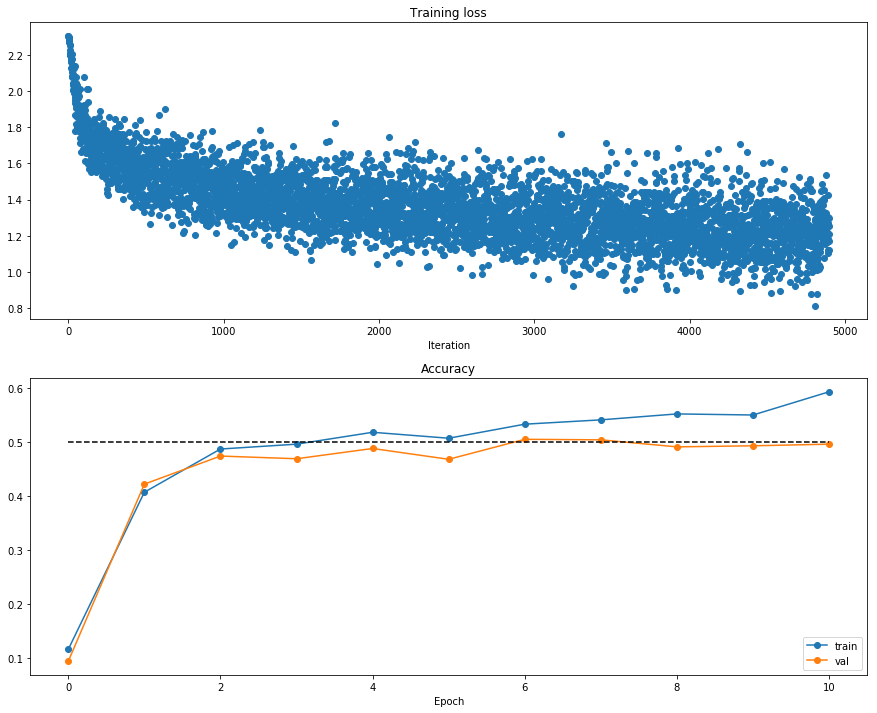

In [143]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class in the file `cs231n/classifiers/fc_net.py`.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout or batch normalization; we will add those features soon.

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors around 1e-6 or less.

In [144]:
np.random.seed(231)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, dtype=np.float64)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    # print(grad_num, grads[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

Running check with reg =  0
Initial loss:  2.30047810196
W1 relative error: 1.42e-06
W2 relative error: 2.06e-04
W3 relative error: 8.90e-07
b1 relative error: 5.32e-07
b2 relative error: 5.17e-07
b3 relative error: 5.04e-07
Running check with reg =  3.14
Initial loss:  7.05211378755
W1 relative error: 9.57e-07
W2 relative error: 1.92e-06
W3 relative error: 3.76e-06
b1 relative error: 5.11e-07
b2 relative error: 5.18e-07
b3 relative error: 5.05e-07


As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. You will need to tweak the learning rate and initialization scale, but you should be able to overfit and achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 2.363363
(Epoch 0 / 20) train acc: 0.180000; val_acc: 0.108000
(Epoch 1 / 20) train acc: 0.320000; val_acc: 0.127000
(Epoch 2 / 20) train acc: 0.440000; val_acc: 0.172000
(Epoch 3 / 20) train acc: 0.500000; val_acc: 0.184000
(Epoch 4 / 20) train acc: 0.540000; val_acc: 0.181000
(Epoch 5 / 20) train acc: 0.740000; val_acc: 0.190000
(Iteration 11 / 40) loss: 0.839976
(Epoch 6 / 20) train acc: 0.740000; val_acc: 0.187000
(Epoch 7 / 20) train acc: 0.740000; val_acc: 0.183000
(Epoch 8 / 20) train acc: 0.820000; val_acc: 0.177000
(Epoch 9 / 20) train acc: 0.860000; val_acc: 0.200000
(Epoch 10 / 20) train acc: 0.920000; val_acc: 0.191000
(Iteration 21 / 40) loss: 0.337174
(Epoch 11 / 20) train acc: 0.960000; val_acc: 0.189000
(Epoch 12 / 20) train acc: 0.940000; val_acc: 0.180000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.199000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.195000
(Iteration 31 / 40) loss: 

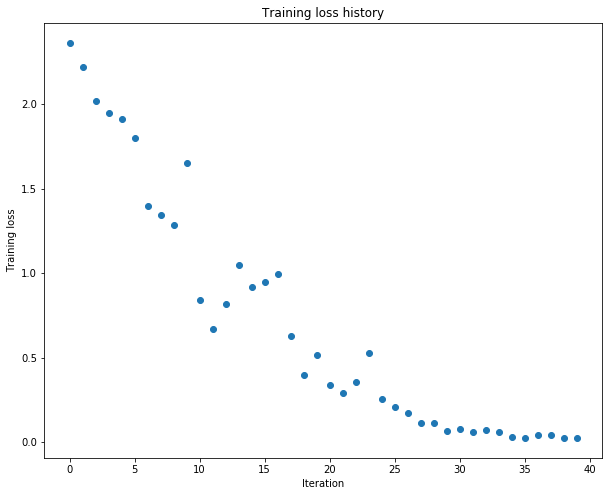

In [145]:
# TODO: Use a three-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

weight_scale = 1e-2
learning_rate = 1e-2
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again you will have to adjust the learning rate and weight initialization, but you should be able to achieve 100% training accuracy within 20 epochs.

(Iteration 1 / 40) loss: 16.118096
(Epoch 0 / 20) train acc: 0.260000; val_acc: 0.110000
(Epoch 1 / 20) train acc: 0.260000; val_acc: 0.089000
(Epoch 2 / 20) train acc: 0.280000; val_acc: 0.098000
(Epoch 3 / 20) train acc: 0.480000; val_acc: 0.130000
(Epoch 4 / 20) train acc: 0.640000; val_acc: 0.122000
(Epoch 5 / 20) train acc: 0.800000; val_acc: 0.102000
(Iteration 11 / 40) loss: 2.083308
(Epoch 6 / 20) train acc: 0.820000; val_acc: 0.108000
(Epoch 7 / 20) train acc: 0.880000; val_acc: 0.117000
(Epoch 8 / 20) train acc: 0.920000; val_acc: 0.121000
(Epoch 9 / 20) train acc: 0.940000; val_acc: 0.117000
(Epoch 10 / 20) train acc: 0.980000; val_acc: 0.125000
(Iteration 21 / 40) loss: 0.644987
(Epoch 11 / 20) train acc: 0.980000; val_acc: 0.117000
(Epoch 12 / 20) train acc: 1.000000; val_acc: 0.115000
(Epoch 13 / 20) train acc: 1.000000; val_acc: 0.113000
(Epoch 14 / 20) train acc: 1.000000; val_acc: 0.113000
(Epoch 15 / 20) train acc: 1.000000; val_acc: 0.114000
(Iteration 31 / 40) loss:

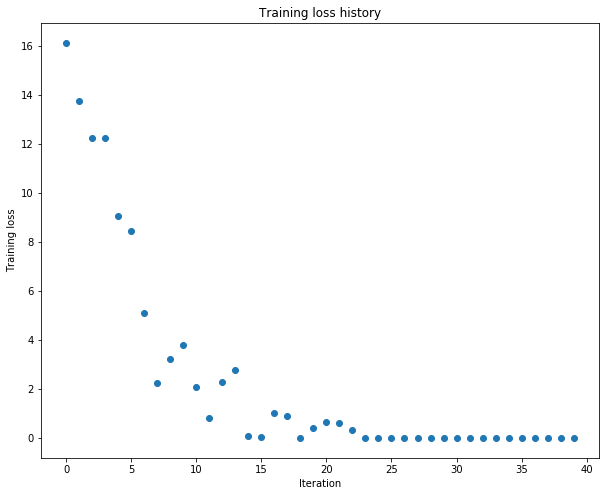

In [146]:
# TODO: Use a five-layer Net to overfit 50 training examples.

num_train = 50
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

learning_rate = 7e-4
weight_scale = 1e-1
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, dtype=np.float64)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                update_rule='sgd',
                optim_config={
                  'learning_rate': learning_rate,
                }
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Inline question: 
Did you notice anything about the comparative difficulty of training the three-layer net vs training the five layer net?

# Answer:
[FILL THIS IN]


# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

# SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochstic gradient descent.

Open the file `cs231n/optim.py` and read the documentation at the top of the file to make sure you understand the API. Implement the SGD+momentum update rule in the function `sgd_momentum` and run the following to check your implementation. You should see errors less than 1e-8.

In [147]:
from cs231n.optim import sgd_momentum

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
v = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = np.asarray([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]])
expected_velocity = np.asarray([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]])

print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

next_w error:  8.88234703351e-09
velocity error:  4.26928774328e-09


Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

running with  sgd
(Iteration 1 / 200) loss: 2.559975
(Epoch 0 / 5) train acc: 0.084000; val_acc: 0.099000
(Iteration 11 / 200) loss: 2.542559
(Iteration 21 / 200) loss: 2.331714
(Iteration 31 / 200) loss: 2.331712
(Epoch 1 / 5) train acc: 0.122000; val_acc: 0.132000
(Iteration 41 / 200) loss: 2.286615
(Iteration 51 / 200) loss: 2.285882
(Iteration 61 / 200) loss: 2.251812
(Iteration 71 / 200) loss: 2.314992
(Epoch 2 / 5) train acc: 0.175000; val_acc: 0.167000
(Iteration 81 / 200) loss: 2.260729
(Iteration 91 / 200) loss: 2.190687
(Iteration 101 / 200) loss: 2.219677
(Iteration 111 / 200) loss: 2.181979
(Epoch 3 / 5) train acc: 0.212000; val_acc: 0.189000
(Iteration 121 / 200) loss: 2.153274
(Iteration 131 / 200) loss: 2.171563
(Iteration 141 / 200) loss: 2.262926
(Iteration 151 / 200) loss: 2.183850
(Epoch 4 / 5) train acc: 0.216000; val_acc: 0.200000
(Iteration 161 / 200) loss: 2.174010
(Iteration 171 / 200) loss: 2.220868
(Iteration 181 / 200) loss: 2.092813
(Iteration 191 / 200) los

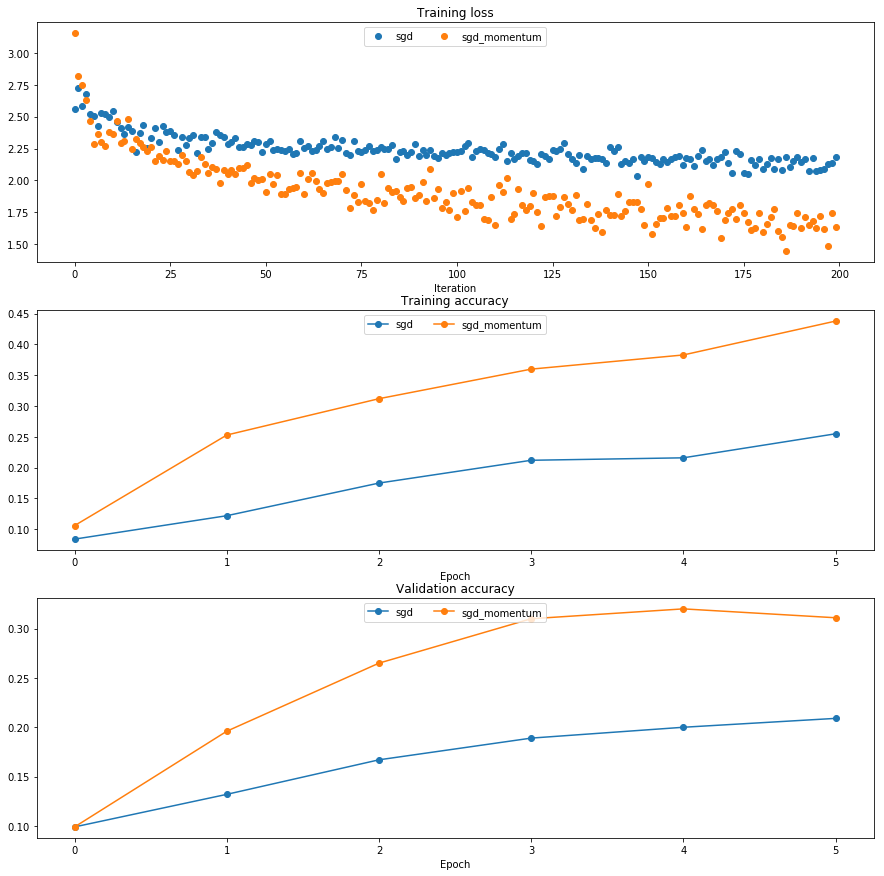

In [148]:
num_train = 4000
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}

for update_rule in ['sgd', 'sgd_momentum']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': 1e-3,
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# RMSProp and Adam
RMSProp [1] and Adam [2] are update rules that set per-parameter learning rates by using a running average of the second moments of gradients.

In the file `cs231n/optim.py`, implement the RMSProp update rule in the `rmsprop` function and implement the Adam update rule in the `adam` function, and check your implementations using the tests below.

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [149]:
# Test RMSProp implementation; you should see errors less than 1e-7
from cs231n.optim import rmsprop

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
cache = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]])
expected_cache = np.asarray([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

next_w error:  9.52468751104e-08
cache error:  2.64779558072e-09


In [150]:
# Test Adam implementation; you should see errors around 1e-7 or less
from cs231n.optim import adam

N, D = 4, 5
w = np.linspace(-0.4, 0.6, num=N*D).reshape(N, D)
dw = np.linspace(-0.6, 0.4, num=N*D).reshape(N, D)
m = np.linspace(0.6, 0.9, num=N*D).reshape(N, D)
v = np.linspace(0.7, 0.5, num=N*D).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = np.asarray([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]])
expected_v = np.asarray([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]])
expected_m = np.asarray([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]])

print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

next_w error:  0.00152184517579
v error:  4.20831403811e-09
m error:  4.21496319311e-09


Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

running with  adam
(Iteration 1 / 200) loss: 3.476915
(Epoch 0 / 5) train acc: 0.126000; val_acc: 0.110000
(Iteration 11 / 200) loss: 2.027711
(Iteration 21 / 200) loss: 2.183356
(Iteration 31 / 200) loss: 1.744256
(Epoch 1 / 5) train acc: 0.363000; val_acc: 0.330000
(Iteration 41 / 200) loss: 1.707950
(Iteration 51 / 200) loss: 1.703834
(Iteration 61 / 200) loss: 2.094564
(Iteration 71 / 200) loss: 1.505556
(Epoch 2 / 5) train acc: 0.419000; val_acc: 0.362000
(Iteration 81 / 200) loss: 1.594429
(Iteration 91 / 200) loss: 1.519015
(Iteration 101 / 200) loss: 1.368522
(Iteration 111 / 200) loss: 1.470399
(Epoch 3 / 5) train acc: 0.460000; val_acc: 0.378000
(Iteration 121 / 200) loss: 1.199063
(Iteration 131 / 200) loss: 1.464704
(Iteration 141 / 200) loss: 1.359862
(Iteration 151 / 200) loss: 1.415065
(Epoch 4 / 5) train acc: 0.521000; val_acc: 0.374000
(Iteration 161 / 200) loss: 1.382817
(Iteration 171 / 200) loss: 1.359899
(Iteration 181 / 200) loss: 1.095947
(Iteration 191 / 200) lo

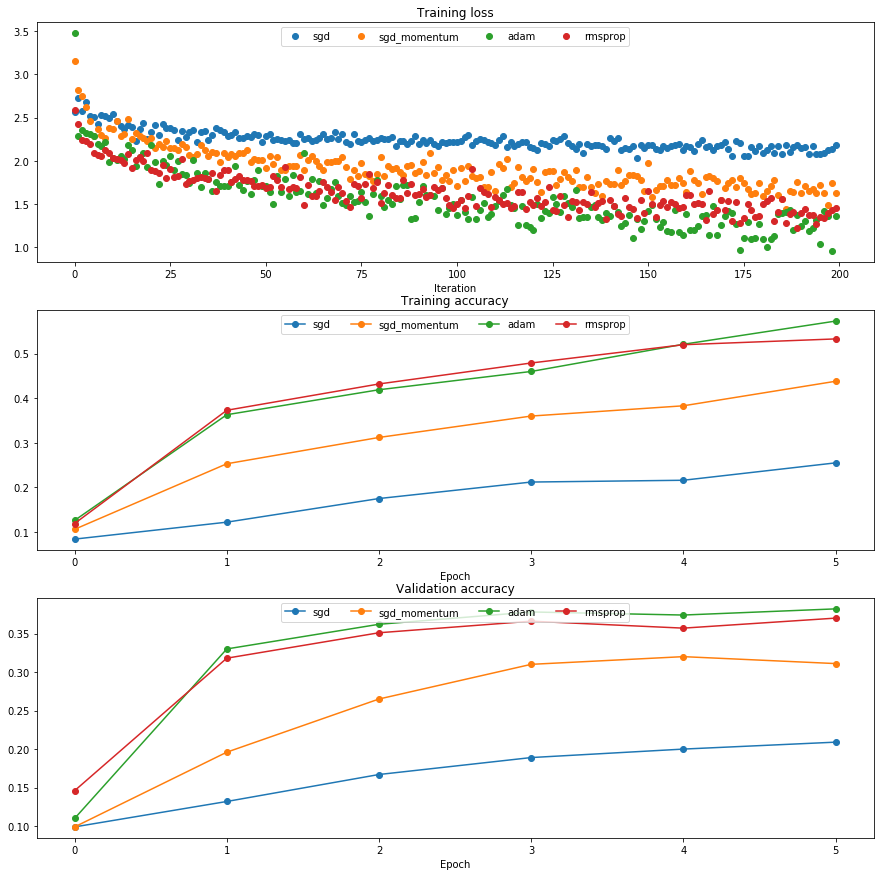

In [151]:
learning_rates = {'rmsprop': 1e-4, 'adam': 1e-3}
for update_rule in ['adam', 'rmsprop']:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule,
                  optim_config={
                    'learning_rate': learning_rates[update_rule]
                  },
                  verbose=True)
  solvers[update_rule] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')

plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')

for update_rule, solver in list(solvers.items()):
  plt.subplot(3, 1, 1)
  plt.plot(solver.loss_history, 'o', label=update_rule)
  
  plt.subplot(3, 1, 2)
  plt.plot(solver.train_acc_history, '-o', label=update_rule)

  plt.subplot(3, 1, 3)
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
  
for i in [1, 2, 3]:
  plt.subplot(3, 1, i)
  plt.legend(loc='upper center', ncol=4)
plt.gcf().set_size_inches(15, 15)
plt.show()

# Train a good model!
Train the best fully-connected model that you can on CIFAR-10, storing your best model in the `best_model` variable. We require you to get at least 50% accuracy on the validation set using a fully-connected net.

If you are careful it should be possible to get accuracies above 55%, but we don't require it for this part and won't assign extra credit for doing so. Later in the assignment we will ask you to train the best convolutional network that you can on CIFAR-10, and we would prefer that you spend your effort working on convolutional nets rather than fully-connected nets.

You might find it useful to complete the `BatchNormalization.ipynb` and `Dropout.ipynb` notebooks before completing this part, since those techniques can help you train powerful models.

In [170]:
best_model = None
################################################################################
# TODO: Train the best FullyConnectedNet that you can on CIFAR-10. You might   #
# batch normalization and dropout useful. Store your best model in the         #
# best_model variable.                                                         #
################################################################################
model = FullyConnectedNet([100, 50], weight_scale=5e-2, dropout=0.7, use_batchnorm=True)

solver = Solver(model, data,
                num_epochs=50, batch_size=50,
                update_rule='adam',
                optim_config={
                    'learning_rate': 1e-3
                },
                verbose=True)
# solvers[update_rule] = solver
solver.train()
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

(Iteration 1 / 49000) loss: 2.297281
(Epoch 0 / 50) train acc: 0.128000; val_acc: 0.129000
(Iteration 11 / 49000) loss: 2.257967
(Iteration 21 / 49000) loss: 2.200072
(Iteration 31 / 49000) loss: 2.107154
(Iteration 41 / 49000) loss: 2.037458
(Iteration 51 / 49000) loss: 2.045679
(Iteration 61 / 49000) loss: 2.010080
(Iteration 71 / 49000) loss: 1.987423
(Iteration 81 / 49000) loss: 2.042332
(Iteration 91 / 49000) loss: 2.055268
(Iteration 101 / 49000) loss: 1.981366
(Iteration 111 / 49000) loss: 2.122526
(Iteration 121 / 49000) loss: 1.913320
(Iteration 131 / 49000) loss: 1.907631
(Iteration 141 / 49000) loss: 1.781260
(Iteration 151 / 49000) loss: 1.762561
(Iteration 161 / 49000) loss: 1.828399
(Iteration 171 / 49000) loss: 1.992605
(Iteration 181 / 49000) loss: 1.856068
(Iteration 191 / 49000) loss: 1.726717
(Iteration 201 / 49000) loss: 2.047157
(Iteration 211 / 49000) loss: 2.040785
(Iteration 221 / 49000) loss: 1.844836
(Iteration 231 / 49000) loss: 1.922794
(Iteration 241 / 4900

(Iteration 2051 / 49000) loss: 1.702316
(Iteration 2061 / 49000) loss: 1.499948
(Iteration 2071 / 49000) loss: 1.729946
(Iteration 2081 / 49000) loss: 1.506555
(Iteration 2091 / 49000) loss: 1.810587
(Iteration 2101 / 49000) loss: 1.472841
(Iteration 2111 / 49000) loss: 1.698102
(Iteration 2121 / 49000) loss: 1.651847
(Iteration 2131 / 49000) loss: 1.883036
(Iteration 2141 / 49000) loss: 1.425560
(Iteration 2151 / 49000) loss: 1.683586
(Iteration 2161 / 49000) loss: 1.692316
(Iteration 2171 / 49000) loss: 1.487347
(Iteration 2181 / 49000) loss: 1.589516
(Iteration 2191 / 49000) loss: 1.574236
(Iteration 2201 / 49000) loss: 1.584198
(Iteration 2211 / 49000) loss: 1.958367
(Iteration 2221 / 49000) loss: 1.644658
(Iteration 2231 / 49000) loss: 1.637527
(Iteration 2241 / 49000) loss: 1.518760
(Iteration 2251 / 49000) loss: 1.682106
(Iteration 2261 / 49000) loss: 1.643937
(Iteration 2271 / 49000) loss: 1.530597
(Iteration 2281 / 49000) loss: 1.823434
(Iteration 2291 / 49000) loss: 1.479327


(Iteration 4081 / 49000) loss: 1.424319
(Iteration 4091 / 49000) loss: 1.482146
(Iteration 4101 / 49000) loss: 1.471902
(Iteration 4111 / 49000) loss: 1.602147
(Iteration 4121 / 49000) loss: 1.621685
(Iteration 4131 / 49000) loss: 1.455411
(Iteration 4141 / 49000) loss: 1.583997
(Iteration 4151 / 49000) loss: 1.319779
(Iteration 4161 / 49000) loss: 1.675371
(Iteration 4171 / 49000) loss: 1.492303
(Iteration 4181 / 49000) loss: 1.463082
(Iteration 4191 / 49000) loss: 1.769444
(Iteration 4201 / 49000) loss: 1.626331
(Iteration 4211 / 49000) loss: 1.482075
(Iteration 4221 / 49000) loss: 1.515676
(Iteration 4231 / 49000) loss: 1.507740
(Iteration 4241 / 49000) loss: 1.590576
(Iteration 4251 / 49000) loss: 1.570847
(Iteration 4261 / 49000) loss: 1.880892
(Iteration 4271 / 49000) loss: 1.345390
(Iteration 4281 / 49000) loss: 1.578962
(Iteration 4291 / 49000) loss: 1.489665
(Iteration 4301 / 49000) loss: 1.742085
(Iteration 4311 / 49000) loss: 1.625803
(Iteration 4321 / 49000) loss: 1.669842


(Iteration 6111 / 49000) loss: 1.394220
(Iteration 6121 / 49000) loss: 1.527578
(Iteration 6131 / 49000) loss: 1.560398
(Iteration 6141 / 49000) loss: 1.419028
(Iteration 6151 / 49000) loss: 1.484751
(Iteration 6161 / 49000) loss: 1.520344
(Iteration 6171 / 49000) loss: 1.334603
(Iteration 6181 / 49000) loss: 1.336339
(Iteration 6191 / 49000) loss: 2.029756
(Iteration 6201 / 49000) loss: 1.525259
(Iteration 6211 / 49000) loss: 1.627892
(Iteration 6221 / 49000) loss: 1.497637
(Iteration 6231 / 49000) loss: 1.486146
(Iteration 6241 / 49000) loss: 1.261946
(Iteration 6251 / 49000) loss: 1.553429
(Iteration 6261 / 49000) loss: 1.239678
(Iteration 6271 / 49000) loss: 1.602151
(Iteration 6281 / 49000) loss: 1.501752
(Iteration 6291 / 49000) loss: 1.551926
(Iteration 6301 / 49000) loss: 1.524516
(Iteration 6311 / 49000) loss: 1.634095
(Iteration 6321 / 49000) loss: 1.497444
(Iteration 6331 / 49000) loss: 1.491655
(Iteration 6341 / 49000) loss: 1.549105
(Iteration 6351 / 49000) loss: 1.296180


(Iteration 8141 / 49000) loss: 1.479010
(Iteration 8151 / 49000) loss: 1.659519
(Iteration 8161 / 49000) loss: 1.431283
(Iteration 8171 / 49000) loss: 1.265768
(Iteration 8181 / 49000) loss: 1.344668
(Iteration 8191 / 49000) loss: 1.295641
(Iteration 8201 / 49000) loss: 1.394305
(Iteration 8211 / 49000) loss: 1.396609
(Iteration 8221 / 49000) loss: 1.746291
(Iteration 8231 / 49000) loss: 1.429135
(Iteration 8241 / 49000) loss: 1.707466
(Iteration 8251 / 49000) loss: 1.166418
(Iteration 8261 / 49000) loss: 1.248442
(Iteration 8271 / 49000) loss: 1.675474
(Iteration 8281 / 49000) loss: 1.420264
(Iteration 8291 / 49000) loss: 1.312704
(Iteration 8301 / 49000) loss: 1.423761
(Iteration 8311 / 49000) loss: 1.522868
(Iteration 8321 / 49000) loss: 1.441239
(Iteration 8331 / 49000) loss: 1.411867
(Iteration 8341 / 49000) loss: 1.350494
(Iteration 8351 / 49000) loss: 1.730526
(Iteration 8361 / 49000) loss: 1.359212
(Iteration 8371 / 49000) loss: 1.706067
(Iteration 8381 / 49000) loss: 1.443752


(Iteration 10161 / 49000) loss: 1.413026
(Iteration 10171 / 49000) loss: 1.467760
(Iteration 10181 / 49000) loss: 1.385177
(Iteration 10191 / 49000) loss: 1.858761
(Iteration 10201 / 49000) loss: 1.498580
(Iteration 10211 / 49000) loss: 1.371576
(Iteration 10221 / 49000) loss: 1.418370
(Iteration 10231 / 49000) loss: 1.457560
(Iteration 10241 / 49000) loss: 1.275747
(Iteration 10251 / 49000) loss: 1.506062
(Iteration 10261 / 49000) loss: 1.479165
(Iteration 10271 / 49000) loss: 1.298931
(Iteration 10281 / 49000) loss: 1.314058
(Iteration 10291 / 49000) loss: 1.465267
(Iteration 10301 / 49000) loss: 1.585385
(Iteration 10311 / 49000) loss: 1.441311
(Iteration 10321 / 49000) loss: 1.431091
(Iteration 10331 / 49000) loss: 1.577288
(Iteration 10341 / 49000) loss: 1.293167
(Iteration 10351 / 49000) loss: 1.676310
(Iteration 10361 / 49000) loss: 1.483265
(Iteration 10371 / 49000) loss: 1.190584
(Iteration 10381 / 49000) loss: 1.170446
(Iteration 10391 / 49000) loss: 1.735954
(Iteration 10401

(Iteration 12151 / 49000) loss: 1.423963
(Iteration 12161 / 49000) loss: 1.294415
(Iteration 12171 / 49000) loss: 1.322726
(Iteration 12181 / 49000) loss: 1.480551
(Iteration 12191 / 49000) loss: 1.430063
(Iteration 12201 / 49000) loss: 1.629027
(Iteration 12211 / 49000) loss: 1.484893
(Iteration 12221 / 49000) loss: 1.051026
(Iteration 12231 / 49000) loss: 1.296270
(Iteration 12241 / 49000) loss: 1.377886
(Iteration 12251 / 49000) loss: 1.066005
(Iteration 12261 / 49000) loss: 1.127139
(Iteration 12271 / 49000) loss: 1.566309
(Iteration 12281 / 49000) loss: 1.477354
(Iteration 12291 / 49000) loss: 1.337636
(Iteration 12301 / 49000) loss: 1.331780
(Iteration 12311 / 49000) loss: 1.458190
(Iteration 12321 / 49000) loss: 1.119353
(Iteration 12331 / 49000) loss: 1.439778
(Iteration 12341 / 49000) loss: 1.388355
(Iteration 12351 / 49000) loss: 1.231655
(Iteration 12361 / 49000) loss: 1.171949
(Iteration 12371 / 49000) loss: 1.294144
(Iteration 12381 / 49000) loss: 1.344491
(Iteration 12391

(Iteration 14141 / 49000) loss: 1.553218
(Iteration 14151 / 49000) loss: 1.553348
(Iteration 14161 / 49000) loss: 1.424317
(Iteration 14171 / 49000) loss: 1.459783
(Iteration 14181 / 49000) loss: 1.354796
(Iteration 14191 / 49000) loss: 1.173385
(Iteration 14201 / 49000) loss: 1.330560
(Iteration 14211 / 49000) loss: 1.292568
(Iteration 14221 / 49000) loss: 1.397117
(Iteration 14231 / 49000) loss: 1.256704
(Iteration 14241 / 49000) loss: 1.610235
(Iteration 14251 / 49000) loss: 1.596551
(Iteration 14261 / 49000) loss: 1.438371
(Iteration 14271 / 49000) loss: 1.629965
(Iteration 14281 / 49000) loss: 1.240280
(Iteration 14291 / 49000) loss: 1.628469
(Iteration 14301 / 49000) loss: 1.693476
(Iteration 14311 / 49000) loss: 1.216373
(Iteration 14321 / 49000) loss: 1.492087
(Iteration 14331 / 49000) loss: 1.393798
(Iteration 14341 / 49000) loss: 1.535445
(Iteration 14351 / 49000) loss: 1.422207
(Iteration 14361 / 49000) loss: 1.397583
(Iteration 14371 / 49000) loss: 1.371678
(Iteration 14381

(Iteration 16121 / 49000) loss: 1.467891
(Iteration 16131 / 49000) loss: 1.328285
(Iteration 16141 / 49000) loss: 1.121779
(Iteration 16151 / 49000) loss: 1.546690
(Iteration 16161 / 49000) loss: 1.449147
(Iteration 16171 / 49000) loss: 1.260574
(Iteration 16181 / 49000) loss: 1.316494
(Iteration 16191 / 49000) loss: 1.536302
(Iteration 16201 / 49000) loss: 1.198980
(Iteration 16211 / 49000) loss: 1.457207
(Iteration 16221 / 49000) loss: 1.066265
(Iteration 16231 / 49000) loss: 1.398033
(Iteration 16241 / 49000) loss: 1.227081
(Iteration 16251 / 49000) loss: 1.362294
(Iteration 16261 / 49000) loss: 1.621903
(Iteration 16271 / 49000) loss: 1.220268
(Iteration 16281 / 49000) loss: 1.471443
(Iteration 16291 / 49000) loss: 1.625867
(Iteration 16301 / 49000) loss: 1.353554
(Iteration 16311 / 49000) loss: 1.396024
(Iteration 16321 / 49000) loss: 1.346503
(Iteration 16331 / 49000) loss: 1.272212
(Iteration 16341 / 49000) loss: 1.533463
(Iteration 16351 / 49000) loss: 1.394357
(Iteration 16361

(Iteration 18101 / 49000) loss: 1.482282
(Iteration 18111 / 49000) loss: 1.202571
(Iteration 18121 / 49000) loss: 1.114792
(Iteration 18131 / 49000) loss: 1.286223
(Iteration 18141 / 49000) loss: 1.453543
(Iteration 18151 / 49000) loss: 1.523080
(Iteration 18161 / 49000) loss: 1.588359
(Iteration 18171 / 49000) loss: 1.269509
(Iteration 18181 / 49000) loss: 1.362561
(Iteration 18191 / 49000) loss: 1.532333
(Iteration 18201 / 49000) loss: 1.366312
(Iteration 18211 / 49000) loss: 1.273689
(Iteration 18221 / 49000) loss: 1.284028
(Iteration 18231 / 49000) loss: 1.454697
(Iteration 18241 / 49000) loss: 1.633662
(Iteration 18251 / 49000) loss: 1.773902
(Iteration 18261 / 49000) loss: 1.453261
(Iteration 18271 / 49000) loss: 1.751565
(Iteration 18281 / 49000) loss: 1.457057
(Iteration 18291 / 49000) loss: 1.333686
(Iteration 18301 / 49000) loss: 1.568614
(Iteration 18311 / 49000) loss: 1.250308
(Iteration 18321 / 49000) loss: 1.304948
(Iteration 18331 / 49000) loss: 1.374919
(Iteration 18341

(Iteration 20081 / 49000) loss: 1.369241
(Iteration 20091 / 49000) loss: 1.220609
(Iteration 20101 / 49000) loss: 1.739348
(Iteration 20111 / 49000) loss: 1.476607
(Iteration 20121 / 49000) loss: 1.215363
(Iteration 20131 / 49000) loss: 1.549478
(Iteration 20141 / 49000) loss: 1.190080
(Iteration 20151 / 49000) loss: 1.418173
(Iteration 20161 / 49000) loss: 1.035616
(Iteration 20171 / 49000) loss: 1.445636
(Iteration 20181 / 49000) loss: 1.440740
(Iteration 20191 / 49000) loss: 1.331589
(Iteration 20201 / 49000) loss: 1.434831
(Iteration 20211 / 49000) loss: 1.346619
(Iteration 20221 / 49000) loss: 1.289431
(Iteration 20231 / 49000) loss: 1.233943
(Iteration 20241 / 49000) loss: 1.288418
(Iteration 20251 / 49000) loss: 1.524098
(Iteration 20261 / 49000) loss: 1.757506
(Iteration 20271 / 49000) loss: 0.991787
(Iteration 20281 / 49000) loss: 1.488293
(Iteration 20291 / 49000) loss: 1.244367
(Iteration 20301 / 49000) loss: 1.207050
(Iteration 20311 / 49000) loss: 1.422505
(Iteration 20321

(Iteration 22061 / 49000) loss: 1.409346
(Iteration 22071 / 49000) loss: 1.444724
(Iteration 22081 / 49000) loss: 1.255198
(Iteration 22091 / 49000) loss: 1.540187
(Iteration 22101 / 49000) loss: 1.333354
(Iteration 22111 / 49000) loss: 1.260913
(Iteration 22121 / 49000) loss: 1.261682
(Iteration 22131 / 49000) loss: 1.374124
(Iteration 22141 / 49000) loss: 1.302748
(Iteration 22151 / 49000) loss: 1.243575
(Iteration 22161 / 49000) loss: 1.164506
(Iteration 22171 / 49000) loss: 1.098629
(Iteration 22181 / 49000) loss: 1.232611
(Iteration 22191 / 49000) loss: 1.802271
(Iteration 22201 / 49000) loss: 1.199691
(Iteration 22211 / 49000) loss: 1.303424
(Iteration 22221 / 49000) loss: 1.599093
(Iteration 22231 / 49000) loss: 1.319091
(Iteration 22241 / 49000) loss: 1.267637
(Iteration 22251 / 49000) loss: 1.371375
(Iteration 22261 / 49000) loss: 1.374605
(Iteration 22271 / 49000) loss: 1.525697
(Iteration 22281 / 49000) loss: 1.516453
(Iteration 22291 / 49000) loss: 1.265322
(Iteration 22301

(Iteration 24051 / 49000) loss: 1.336667
(Iteration 24061 / 49000) loss: 1.122236
(Iteration 24071 / 49000) loss: 1.393083
(Iteration 24081 / 49000) loss: 1.307966
(Iteration 24091 / 49000) loss: 1.228843
(Iteration 24101 / 49000) loss: 1.482807
(Iteration 24111 / 49000) loss: 1.341033
(Iteration 24121 / 49000) loss: 1.325639
(Iteration 24131 / 49000) loss: 1.417309
(Iteration 24141 / 49000) loss: 1.164668
(Iteration 24151 / 49000) loss: 1.399469
(Iteration 24161 / 49000) loss: 1.450125
(Iteration 24171 / 49000) loss: 1.454914
(Iteration 24181 / 49000) loss: 1.107231
(Iteration 24191 / 49000) loss: 1.283606
(Iteration 24201 / 49000) loss: 1.532859
(Iteration 24211 / 49000) loss: 1.522820
(Iteration 24221 / 49000) loss: 1.625196
(Iteration 24231 / 49000) loss: 1.318089
(Iteration 24241 / 49000) loss: 1.146507
(Iteration 24251 / 49000) loss: 1.575307
(Iteration 24261 / 49000) loss: 1.182330
(Iteration 24271 / 49000) loss: 1.317292
(Iteration 24281 / 49000) loss: 1.470191
(Iteration 24291

(Iteration 26041 / 49000) loss: 1.140223
(Iteration 26051 / 49000) loss: 1.379844
(Iteration 26061 / 49000) loss: 1.208439
(Iteration 26071 / 49000) loss: 1.068629
(Iteration 26081 / 49000) loss: 1.168033
(Iteration 26091 / 49000) loss: 1.622004
(Iteration 26101 / 49000) loss: 1.419568
(Iteration 26111 / 49000) loss: 1.580927
(Iteration 26121 / 49000) loss: 1.474232
(Iteration 26131 / 49000) loss: 1.370658
(Iteration 26141 / 49000) loss: 1.059202
(Iteration 26151 / 49000) loss: 1.414493
(Iteration 26161 / 49000) loss: 1.328189
(Iteration 26171 / 49000) loss: 1.176334
(Iteration 26181 / 49000) loss: 1.396947
(Iteration 26191 / 49000) loss: 1.227530
(Iteration 26201 / 49000) loss: 1.241989
(Iteration 26211 / 49000) loss: 1.445085
(Iteration 26221 / 49000) loss: 1.614184
(Iteration 26231 / 49000) loss: 1.552004
(Iteration 26241 / 49000) loss: 1.099268
(Iteration 26251 / 49000) loss: 1.252236
(Iteration 26261 / 49000) loss: 1.423991
(Iteration 26271 / 49000) loss: 1.055832
(Iteration 26281

(Iteration 28021 / 49000) loss: 1.556756
(Iteration 28031 / 49000) loss: 1.353620
(Iteration 28041 / 49000) loss: 1.155069
(Iteration 28051 / 49000) loss: 1.171811
(Iteration 28061 / 49000) loss: 1.553875
(Iteration 28071 / 49000) loss: 1.272580
(Iteration 28081 / 49000) loss: 1.087760
(Iteration 28091 / 49000) loss: 1.392576
(Iteration 28101 / 49000) loss: 1.114482
(Iteration 28111 / 49000) loss: 1.238803
(Iteration 28121 / 49000) loss: 1.254303
(Iteration 28131 / 49000) loss: 1.780012
(Iteration 28141 / 49000) loss: 1.295961
(Iteration 28151 / 49000) loss: 1.163230
(Iteration 28161 / 49000) loss: 1.270386
(Iteration 28171 / 49000) loss: 1.279734
(Iteration 28181 / 49000) loss: 1.241208
(Iteration 28191 / 49000) loss: 1.573799
(Iteration 28201 / 49000) loss: 1.701403
(Iteration 28211 / 49000) loss: 1.109771
(Iteration 28221 / 49000) loss: 1.128915
(Iteration 28231 / 49000) loss: 1.250253
(Iteration 28241 / 49000) loss: 1.471457
(Iteration 28251 / 49000) loss: 1.098508
(Iteration 28261

(Iteration 30001 / 49000) loss: 1.436980
(Iteration 30011 / 49000) loss: 1.381228
(Iteration 30021 / 49000) loss: 1.431937
(Iteration 30031 / 49000) loss: 1.594695
(Iteration 30041 / 49000) loss: 1.323363
(Iteration 30051 / 49000) loss: 1.151482
(Iteration 30061 / 49000) loss: 1.040582
(Iteration 30071 / 49000) loss: 1.209976
(Iteration 30081 / 49000) loss: 1.165639
(Iteration 30091 / 49000) loss: 1.108172
(Iteration 30101 / 49000) loss: 1.141403
(Iteration 30111 / 49000) loss: 1.227773
(Iteration 30121 / 49000) loss: 1.250166
(Iteration 30131 / 49000) loss: 1.428825
(Iteration 30141 / 49000) loss: 1.206590
(Iteration 30151 / 49000) loss: 1.294533
(Iteration 30161 / 49000) loss: 1.208436
(Iteration 30171 / 49000) loss: 1.685080
(Iteration 30181 / 49000) loss: 1.586364
(Iteration 30191 / 49000) loss: 1.563678
(Iteration 30201 / 49000) loss: 1.128958
(Iteration 30211 / 49000) loss: 1.620802
(Iteration 30221 / 49000) loss: 1.333575
(Iteration 30231 / 49000) loss: 1.362045
(Iteration 30241

(Iteration 31981 / 49000) loss: 1.622361
(Iteration 31991 / 49000) loss: 1.413751
(Iteration 32001 / 49000) loss: 1.269271
(Iteration 32011 / 49000) loss: 1.339982
(Iteration 32021 / 49000) loss: 1.432150
(Iteration 32031 / 49000) loss: 1.271281
(Iteration 32041 / 49000) loss: 1.171786
(Iteration 32051 / 49000) loss: 1.377143
(Iteration 32061 / 49000) loss: 1.539462
(Iteration 32071 / 49000) loss: 1.233601
(Iteration 32081 / 49000) loss: 1.661382
(Iteration 32091 / 49000) loss: 1.070764
(Iteration 32101 / 49000) loss: 1.209956
(Iteration 32111 / 49000) loss: 1.082545
(Iteration 32121 / 49000) loss: 1.206448
(Iteration 32131 / 49000) loss: 1.384847
(Iteration 32141 / 49000) loss: 1.457969
(Iteration 32151 / 49000) loss: 1.208217
(Iteration 32161 / 49000) loss: 1.656242
(Iteration 32171 / 49000) loss: 1.484399
(Iteration 32181 / 49000) loss: 1.309582
(Iteration 32191 / 49000) loss: 1.262671
(Iteration 32201 / 49000) loss: 1.264407
(Iteration 32211 / 49000) loss: 1.320355
(Iteration 32221

(Iteration 33961 / 49000) loss: 1.319649
(Iteration 33971 / 49000) loss: 1.347469
(Iteration 33981 / 49000) loss: 1.329753
(Iteration 33991 / 49000) loss: 1.049057
(Iteration 34001 / 49000) loss: 1.127762
(Iteration 34011 / 49000) loss: 1.160153
(Iteration 34021 / 49000) loss: 1.415534
(Iteration 34031 / 49000) loss: 1.444019
(Iteration 34041 / 49000) loss: 1.336471
(Iteration 34051 / 49000) loss: 1.221994
(Iteration 34061 / 49000) loss: 1.123200
(Iteration 34071 / 49000) loss: 1.256507
(Iteration 34081 / 49000) loss: 1.144622
(Iteration 34091 / 49000) loss: 1.427393
(Iteration 34101 / 49000) loss: 1.074597
(Iteration 34111 / 49000) loss: 1.239496
(Iteration 34121 / 49000) loss: 1.175643
(Iteration 34131 / 49000) loss: 1.338965
(Iteration 34141 / 49000) loss: 1.314141
(Iteration 34151 / 49000) loss: 1.515831
(Iteration 34161 / 49000) loss: 1.244242
(Iteration 34171 / 49000) loss: 1.046106
(Iteration 34181 / 49000) loss: 1.157151
(Iteration 34191 / 49000) loss: 1.562239
(Iteration 34201

(Iteration 35941 / 49000) loss: 1.493135
(Iteration 35951 / 49000) loss: 1.300171
(Iteration 35961 / 49000) loss: 0.999053
(Iteration 35971 / 49000) loss: 1.466354
(Iteration 35981 / 49000) loss: 1.244120
(Iteration 35991 / 49000) loss: 1.215681
(Iteration 36001 / 49000) loss: 1.111847
(Iteration 36011 / 49000) loss: 1.125281
(Iteration 36021 / 49000) loss: 1.713237
(Iteration 36031 / 49000) loss: 1.368417
(Iteration 36041 / 49000) loss: 1.289122
(Iteration 36051 / 49000) loss: 1.131172
(Iteration 36061 / 49000) loss: 1.293304
(Iteration 36071 / 49000) loss: 1.196064
(Iteration 36081 / 49000) loss: 1.427220
(Iteration 36091 / 49000) loss: 1.568362
(Iteration 36101 / 49000) loss: 1.279861
(Iteration 36111 / 49000) loss: 1.295613
(Iteration 36121 / 49000) loss: 1.470885
(Iteration 36131 / 49000) loss: 1.370167
(Iteration 36141 / 49000) loss: 1.399679
(Iteration 36151 / 49000) loss: 1.249065
(Iteration 36161 / 49000) loss: 1.396911
(Iteration 36171 / 49000) loss: 1.353330
(Iteration 36181

(Iteration 37921 / 49000) loss: 1.316203
(Iteration 37931 / 49000) loss: 1.382446
(Iteration 37941 / 49000) loss: 1.262898
(Iteration 37951 / 49000) loss: 1.328868
(Iteration 37961 / 49000) loss: 1.268619
(Iteration 37971 / 49000) loss: 1.112741
(Iteration 37981 / 49000) loss: 1.363053
(Iteration 37991 / 49000) loss: 1.221254
(Iteration 38001 / 49000) loss: 1.238171
(Iteration 38011 / 49000) loss: 1.623091
(Iteration 38021 / 49000) loss: 1.402086
(Iteration 38031 / 49000) loss: 1.269762
(Iteration 38041 / 49000) loss: 1.262556
(Iteration 38051 / 49000) loss: 1.379921
(Iteration 38061 / 49000) loss: 1.083926
(Iteration 38071 / 49000) loss: 1.365220
(Iteration 38081 / 49000) loss: 1.061468
(Iteration 38091 / 49000) loss: 1.083202
(Iteration 38101 / 49000) loss: 1.144903
(Iteration 38111 / 49000) loss: 1.131498
(Iteration 38121 / 49000) loss: 1.172932
(Iteration 38131 / 49000) loss: 1.294628
(Iteration 38141 / 49000) loss: 1.185941
(Iteration 38151 / 49000) loss: 1.099041
(Iteration 38161

(Iteration 39901 / 49000) loss: 1.243595
(Iteration 39911 / 49000) loss: 1.193841
(Iteration 39921 / 49000) loss: 1.293523
(Iteration 39931 / 49000) loss: 1.032842
(Iteration 39941 / 49000) loss: 1.329773
(Iteration 39951 / 49000) loss: 1.201696
(Iteration 39961 / 49000) loss: 1.205314
(Iteration 39971 / 49000) loss: 1.103493
(Iteration 39981 / 49000) loss: 1.592494
(Iteration 39991 / 49000) loss: 1.061973
(Iteration 40001 / 49000) loss: 1.203091
(Iteration 40011 / 49000) loss: 1.280645
(Iteration 40021 / 49000) loss: 1.462937
(Iteration 40031 / 49000) loss: 1.084558
(Iteration 40041 / 49000) loss: 1.209936
(Iteration 40051 / 49000) loss: 1.430070
(Iteration 40061 / 49000) loss: 1.248373
(Iteration 40071 / 49000) loss: 1.640351
(Iteration 40081 / 49000) loss: 1.503407
(Iteration 40091 / 49000) loss: 1.082903
(Iteration 40101 / 49000) loss: 1.333168
(Iteration 40111 / 49000) loss: 1.270484
(Iteration 40121 / 49000) loss: 1.212918
(Iteration 40131 / 49000) loss: 1.145615
(Iteration 40141

(Iteration 41881 / 49000) loss: 0.981113
(Iteration 41891 / 49000) loss: 1.223038
(Iteration 41901 / 49000) loss: 1.255746
(Iteration 41911 / 49000) loss: 1.320316
(Iteration 41921 / 49000) loss: 1.333128
(Iteration 41931 / 49000) loss: 1.308225
(Iteration 41941 / 49000) loss: 1.905753
(Iteration 41951 / 49000) loss: 1.049473
(Iteration 41961 / 49000) loss: 1.279458
(Iteration 41971 / 49000) loss: 1.552802
(Iteration 41981 / 49000) loss: 1.512645
(Iteration 41991 / 49000) loss: 1.448676
(Iteration 42001 / 49000) loss: 1.441271
(Iteration 42011 / 49000) loss: 1.154395
(Iteration 42021 / 49000) loss: 1.297397
(Iteration 42031 / 49000) loss: 1.121332
(Iteration 42041 / 49000) loss: 1.280697
(Iteration 42051 / 49000) loss: 1.262711
(Iteration 42061 / 49000) loss: 1.246890
(Iteration 42071 / 49000) loss: 1.169097
(Iteration 42081 / 49000) loss: 1.322764
(Iteration 42091 / 49000) loss: 1.285359
(Iteration 42101 / 49000) loss: 1.289661
(Iteration 42111 / 49000) loss: 1.050266
(Iteration 42121

(Iteration 43861 / 49000) loss: 1.595753
(Iteration 43871 / 49000) loss: 1.301227
(Iteration 43881 / 49000) loss: 1.379706
(Iteration 43891 / 49000) loss: 1.379953
(Iteration 43901 / 49000) loss: 1.042470
(Iteration 43911 / 49000) loss: 1.420114
(Iteration 43921 / 49000) loss: 1.107506
(Iteration 43931 / 49000) loss: 1.422810
(Iteration 43941 / 49000) loss: 1.299839
(Iteration 43951 / 49000) loss: 1.103591
(Iteration 43961 / 49000) loss: 1.347174
(Iteration 43971 / 49000) loss: 1.124590
(Iteration 43981 / 49000) loss: 1.047063
(Iteration 43991 / 49000) loss: 1.321625
(Iteration 44001 / 49000) loss: 1.264695
(Iteration 44011 / 49000) loss: 1.091599
(Iteration 44021 / 49000) loss: 1.257018
(Iteration 44031 / 49000) loss: 1.328544
(Iteration 44041 / 49000) loss: 1.496874
(Iteration 44051 / 49000) loss: 1.069639
(Iteration 44061 / 49000) loss: 1.345316
(Iteration 44071 / 49000) loss: 1.178603
(Iteration 44081 / 49000) loss: 1.244633
(Iteration 44091 / 49000) loss: 1.330321
(Epoch 45 / 50) 

(Iteration 45841 / 49000) loss: 1.069739
(Iteration 45851 / 49000) loss: 1.492142
(Iteration 45861 / 49000) loss: 1.347977
(Iteration 45871 / 49000) loss: 1.271370
(Iteration 45881 / 49000) loss: 1.453084
(Iteration 45891 / 49000) loss: 1.289427
(Iteration 45901 / 49000) loss: 1.001086
(Iteration 45911 / 49000) loss: 1.207998
(Iteration 45921 / 49000) loss: 1.124863
(Iteration 45931 / 49000) loss: 1.501014
(Iteration 45941 / 49000) loss: 1.527947
(Iteration 45951 / 49000) loss: 1.159186
(Iteration 45961 / 49000) loss: 1.218728
(Iteration 45971 / 49000) loss: 1.272229
(Iteration 45981 / 49000) loss: 1.161062
(Iteration 45991 / 49000) loss: 0.886103
(Iteration 46001 / 49000) loss: 1.201997
(Iteration 46011 / 49000) loss: 1.362137
(Iteration 46021 / 49000) loss: 1.201520
(Iteration 46031 / 49000) loss: 1.406547
(Iteration 46041 / 49000) loss: 1.130227
(Iteration 46051 / 49000) loss: 1.315223
(Epoch 47 / 50) train acc: 0.649000; val_acc: 0.522000
(Iteration 46061 / 49000) loss: 1.578938
(I

(Iteration 47831 / 49000) loss: 1.232049
(Iteration 47841 / 49000) loss: 1.134628
(Iteration 47851 / 49000) loss: 1.533627
(Iteration 47861 / 49000) loss: 1.102569
(Iteration 47871 / 49000) loss: 1.145992
(Iteration 47881 / 49000) loss: 1.219107
(Iteration 47891 / 49000) loss: 1.302218
(Iteration 47901 / 49000) loss: 1.625548
(Iteration 47911 / 49000) loss: 1.592406
(Iteration 47921 / 49000) loss: 1.228317
(Iteration 47931 / 49000) loss: 1.184422
(Iteration 47941 / 49000) loss: 1.136164
(Iteration 47951 / 49000) loss: 1.210573
(Iteration 47961 / 49000) loss: 1.206724
(Iteration 47971 / 49000) loss: 1.317098
(Iteration 47981 / 49000) loss: 1.294451
(Iteration 47991 / 49000) loss: 1.163648
(Iteration 48001 / 49000) loss: 1.001268
(Iteration 48011 / 49000) loss: 1.122022
(Epoch 49 / 50) train acc: 0.672000; val_acc: 0.523000
(Iteration 48021 / 49000) loss: 1.532027
(Iteration 48031 / 49000) loss: 1.302791
(Iteration 48041 / 49000) loss: 1.250372
(Iteration 48051 / 49000) loss: 1.264538
(I

In [171]:
best_model=model

# Test you model
Run your best model on the validation and test sets. You should achieve above 50% accuracy on the validation set.

In [172]:
y_test_pred = np.argmax(best_model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(best_model.loss(data['X_val']), axis=1)
print('Validation set accuracy: ', (y_val_pred == data['y_val']).mean())
print('Test set accuracy: ', (y_test_pred == data['y_test']).mean())

Validation set accuracy:  0.523
Test set accuracy:  0.504
